<a href="https://colab.research.google.com/github/AliEbadi110/Computer-Vision-Image-Classification-Sample-Projects/blob/main/Computer_Vision_PyTorch_Image_Classification_CNN_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision - PyTorch - Image Classification - CNN - CIFAR 10**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## 1. Loading Data

In [ ]:
transformer_train = torchvision.transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transformer_train,
    download=True)

Files already downloaded and verified


In [ ]:
test_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

Files already downloaded and verified


## 2. Data Overview

In [ ]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [ ]:
test_dataset.data.shape

(10000, 32, 32, 3)

In [ ]:
type(test_dataset.data[0])

numpy.ndarray

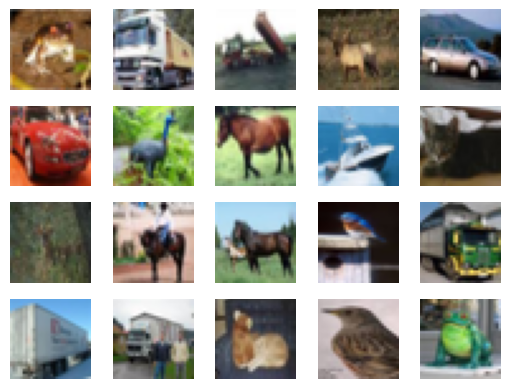

In [ ]:
figure = plt.figure()
num_of_images = 20

for i in range(num_of_images):
  plt.subplot(4, 5, i+1)
  plt.axis('off')
  plt.imshow(train_dataset.data[i])

## 3. Target Variable Preprocessing

In [ ]:
pd.Series(test_dataset.targets).value_counts()

3    1000
8    1000
0    1000
6    1000
1    1000
9    1000
5    1000
7    1000
4    1000
2    1000
dtype: int64

<Axes: >

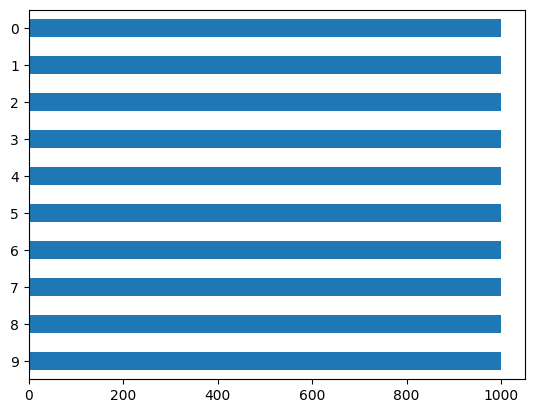

In [ ]:
pd.Series(test_dataset.targets).value_counts().sort_index(ascending=False).plot(kind = 'barh')

## 4. Build Model

In [ ]:
# h_out = ((h_in+(2*padding[0])-(dilation[0]*(kernel_size[0]-1))-1)/stride[0])+1
print(np.floor((32+(2*1)-(1*(3-1))-1)/1)+1)
print(np.floor((16+(2*1)-(1*(3-1))-1)/1)+1)
print(np.floor((8+(2*1)-(1*(3-1))-1)/1)+1)
print(np.floor((4+(2*1)-(1*(3-1))-1)/1)+1)

32.0
16.0
8.0
4.0


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.MaxPool2d(2),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(64),
      nn.MaxPool2d(2),
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(128),
      nn.MaxPool2d(2))
    self.dense_layers = nn.Sequential(
      nn.Flatten(),
      nn.Dropout(0.5),
      nn.Linear(128*4*4, 1024),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(1024, 10))

  def forward(self, x):
    x = self.conv_layers(x)
    y_pred = self.dense_layers(x)
    return y_pred

In [ ]:
model = Model()

In [ ]:
model.parameters
model.to(device)

Model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [ ]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## 5. Train Model

In [ ]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

In [ ]:
n_epochs = 30
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for i in range(n_epochs):

  model.train()
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs_train = model(inputs)
    loss_train = criterion(outputs_train, targets)

    loss_train.backward()
    optimizer.step()

    train_loss.append(loss_train.item())

  train_loss = np.mean(train_loss)
  train_losses[i] = train_loss

  model.eval()
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs_train = model(inputs)
    loss_test = criterion(outputs_train, targets)

    test_loss.append(loss_test.item())

  test_loss = np.mean(test_loss)

  test_losses[i] = test_loss

  print(f'Epoch {i+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/30, Train Loss: 1.4425, Test Loss: 1.1019
Epoch 2/30, Train Loss: 1.0268, Test Loss: 0.9040
Epoch 3/30, Train Loss: 0.8637, Test Loss: 0.8608
Epoch 4/30, Train Loss: 0.7674, Test Loss: 0.7200
Epoch 5/30, Train Loss: 0.7092, Test Loss: 0.7102
Epoch 6/30, Train Loss: 0.6512, Test Loss: 0.6509
Epoch 7/30, Train Loss: 0.6187, Test Loss: 0.6254
Epoch 8/30, Train Loss: 0.5789, Test Loss: 0.5902
Epoch 9/30, Train Loss: 0.5575, Test Loss: 0.5066
Epoch 10/30, Train Loss: 0.5380, Test Loss: 0.5053
Epoch 11/30, Train Loss: 0.5156, Test Loss: 0.5332
Epoch 12/30, Train Loss: 0.4952, Test Loss: 0.4869
Epoch 13/30, Train Loss: 0.4734, Test Loss: 0.5783
Epoch 14/30, Train Loss: 0.4621, Test Loss: 0.4995
Epoch 15/30, Train Loss: 0.4521, Test Loss: 0.5244
Epoch 16/30, Train Loss: 0.4470, Test Loss: 0.4714
Epoch 17/30, Train Loss: 0.4248, Test Loss: 0.4931
Epoch 18/30, Train Loss: 0.4184, Test Loss: 0.4333
Epoch 19/30, Train Loss: 0.4055, Test Loss: 0.4267
Epoch 20/30, Train Loss: 0.3985, Test Lo

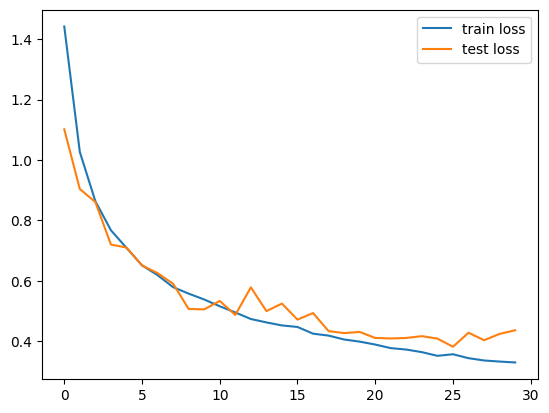

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

## 6. Predict, Evaluate

In [ ]:
model.eval()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

In [ ]:
y_test = np.array(test_dataset.targets)

In [ ]:
print(classification_report(p_test, y_test))

              precision    recall  f1-score   support

         0.0       0.83      0.91      0.87       922
         1.0       0.95      0.92      0.94      1031
         2.0       0.78      0.87      0.82       900
         3.0       0.84      0.62      0.72      1356
         4.0       0.85      0.87      0.86       973
         5.0       0.77      0.82      0.79       931
         6.0       0.90      0.88      0.89      1027
         7.0       0.85      0.92      0.89       923
         8.0       0.90      0.95      0.92       949
         9.0       0.92      0.93      0.92       988

    accuracy                           0.86     10000
   macro avg       0.86      0.87      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [ ]:
print(confusion_matrix(p_test, y_test))

[[835   4  30   4   3   2   4   5  24  11]
 [ 10 952   2   3   1   2   2   1  17  41]
 [ 25   0 782  16  23  16  19   8   7   4]
 [ 54   3  77 845  61 171  53  47  32  13]
 [  8   0  35  27 850  14   8  28   2   1]
 [  2   1  19  61  20 766   8  47   5   2]
 [  8   2  43  24  24  12 903   6   2   3]
 [  9   0   7  14  17  16   2 853   3   2]
 [ 30   7   3   1   1   0   1   1 898   7]
 [ 19  31   2   5   0   1   0   4  10 916]]


In [ ]:
labels = '''ariplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split('\n')

Text(0.5, 1.0, 'True label: dog   Predicted: cat')

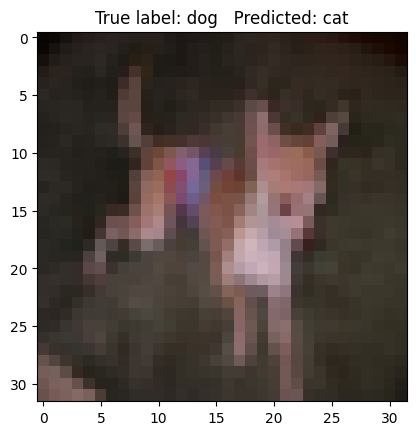

In [ ]:
X_test = test_dataset.data
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i].reshape(32, 32, 3))
plt.title(f'True label: {labels[y_test[i]]}   Predicted: {labels[p_test[i]]}')